In [1]:
#%pip install -U torch matplotlib
import torch as pt
import matplotlib.pyplot as plt
from functools import partial
from enum import IntEnum
from collections import namedtuple

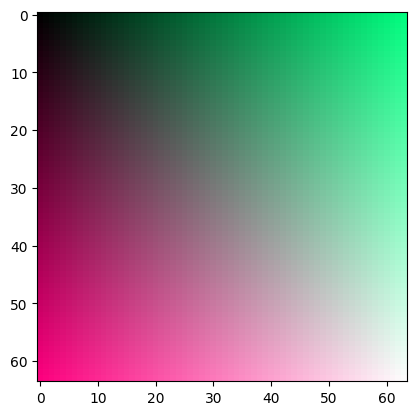

In [2]:
plt.imshow([[[j*4,i*4,(j+i)*2] for i in range(64)] for j in range(64)])

In [3]:
Material = namedtuple('Material', ['refractive_index', 'albedo', 'diffuse_color', 'specular_exponent'])
Sphere = namedtuple('Sphere', ['center', 'radius', 'material'])
# IVORY, GLASS, RED_RUBBER, MIRROR
material = Material([],[],pt.tensor([[.4,.4,.3],[.6,.7,.8],[.3,.1,.1],[1,1,1]]),[])
sphere = Sphere(pt.tensor([[-3,0,-16],[-1,-1.5,-12],[1.5,-.5,-18],[7,5,-18]]),
                pt.tensor([2.,2,3,4]),
                material)
light = pt.tensor([[-20.,20,20],[30,50,-25],[30,20,35]])
null = pt.tensor([0.,0.,0.])
sphere, light, null

(Sphere(center=tensor([[ -3.0000,   0.0000, -16.0000],
         [ -1.0000,  -1.5000, -12.0000],
         [  1.5000,  -0.5000, -18.0000],
         [  7.0000,   5.0000, -18.0000]]), radius=tensor([2., 2., 3., 4.]), material=Material(refractive_index=[], albedo=[], diffuse_color=tensor([[0.4000, 0.4000, 0.3000],
         [0.6000, 0.7000, 0.8000],
         [0.3000, 0.1000, 0.1000],
         [1.0000, 1.0000, 1.0000]]), specular_exponent=[])),
 tensor([[-20.,  20.,  20.],
         [ 30.,  50., -25.],
         [ 30.,  20.,  35.]]),
 tensor([0., 0., 0.]))

In [4]:

def ray_intersect(orig, dir, center, raduis):
    oc = center - orig
    l2 = oc@oc
    ip = oc@dir
    d2 = dir@dir
    p2 = ip*ip/d2
    r2 = raduis*raduis
    hit = (ip>0) & (l2 - p2 < r2) & (r2 < l2)
    return hit, pt.where(hit, pt.sqrt(p2)-pt.sqrt(r2-(l2-p2)), pt.inf)
ray_intersect(pt.tensor([0.,0.,0.]), pt.tensor([0.,12.*35/37,-35.*35/37]), pt.tensor([0.,0.,-37.]), 13.)
#pt.vmap(partial(ray_intersect, pt.tensor([0.,0,0]), pt.tensor([0.,0,-1])))(sphere.center, sphere.radius)

(tensor(True), tensor(30.))

In [5]:
def scene_intersect(orig, dir, scene):
    hit, dist = pt.vmap(partial(ray_intersect, orig, dir))(scene.center, scene.radius)
    nearest_idx = dist.argmin(keepdim=True)
    h = hit[nearest_idx]
    norm_dir = dir/pt.norm(dir)
    point = norm_dir * dist[nearest_idx]
    N = point-scene.center[nearest_idx]
    NN = N/pt.norm(N)
    return h, point, NN[0], scene.material.diffuse_color[nearest_idx][0]
scene_intersect(null, pt.tensor([0.,0,-1]), sphere)
#pt.vmap(partial(scene_intersect, null, scene = sphere))(pt.tensor([[0.,0,-1]]))

(tensor([True]),
 tensor([  0.0000,   0.0000, -11.1340]),
 tensor([0.5000, 0.7500, 0.4330]),
 tensor([0.6000, 0.7000, 0.8000]))

In [6]:
def cast_ray(orig, dir, scene, light):
    hit, point, N, color = scene_intersect(orig, dir, scene)
    light_dir = light-point
    NL = light_dir/pt.norm(light_dir, dim=-1, keepdim=True)
    diffuse_light_intensity = pt.max(pt.vmap(partial(pt.dot, N))(NL), pt.tensor(0.))
    #print(diffuse_light_intensity.sum())
    return pt.where(hit, color*diffuse_light_intensity.sum(), pt.tensor([0.2,0.7,0.8]))
cast_ray(pt.tensor([0.,0,0]), pt.tensor([0.,0,-1]), sphere, light)
pt.vmap(partial(cast_ray, pt.tensor([0.,0.,0.]), scene = sphere, light=light))(pt.tensor([[0.,0,-1]]))

tensor([[1.2412, 1.4481, 1.6549]])

In [7]:
def make_frame(weight,height):
    ratio = height/weight
    return pt.stack([pt.tile(pt.linspace(-1,1,weight), (height,1)),pt.tile(pt.linspace(ratio,-ratio,height).reshape(height,1), (weight,)),pt.tile(pt.tensor(-1), (height,weight))],2)

In [8]:
weight=1024#7680
height=768#4320
frame=make_frame(weight,height)
fc = partial(cast_ray, pt.tensor([0.,0.,0.]), scene = sphere, light= light)

In [9]:
img=pt.vmap(fc)(frame.reshape(weight*height,3)).reshape(height,weight,3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


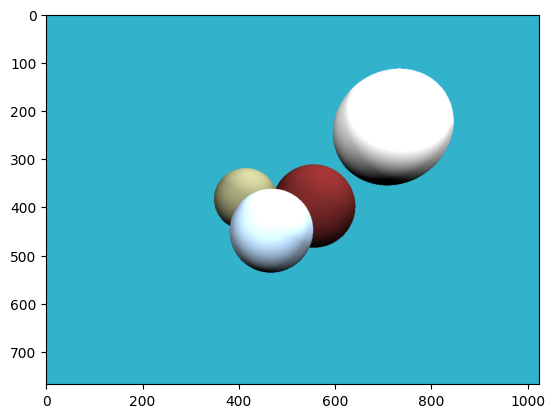

In [10]:
plt.imshow(img)